In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score
import xgboost as xgb

In [2]:
df = pd.read_csv('/content/USvideos.csv')
all_category = pd.read_json('/content/US_category_id.json')
for i in range(3):
  print(all_category['items'][i])

{'kind': 'youtube#videoCategory', 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKmPBggty2mZQ"', 'id': '1', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Film & Animation', 'assignable': True}}
{'kind': 'youtube#videoCategory', 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/UZ1oLIIz2dxIhO45ZTFR3a3NyTA"', 'id': '2', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Autos & Vehicles', 'assignable': True}}
{'kind': 'youtube#videoCategory', 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/nqRIq97-xe5XRZTxbknKFVe5Lmg"', 'id': '10', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Music', 'assignable': True}}


In [3]:
# Reomve error videos
df = df[df['video_error_or_removed'] == False].copy()

# Identify rows with '#NAME?' video_id (missing video_id)
problem_rows = df[df['video_id'] == '#NAME?']

# Create a new identifier for these rows
new_ids = problem_rows.apply(lambda row: f"{row['title']}_{row['category_id']}", axis=1)

# Update the 'video_id' column for the problematic rows
df.loc[problem_rows.index, 'video_id'] = new_ids

# Feature engineering
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['trending_year'] = df['trending_date'].dt.year
df['trending_month'] = df['trending_date'].dt.month
df['trending_dayofweek'] = df['trending_date'].dt.dayofweek
df['publish_hour'] = df['publish_time'].dt.hour
df['time_takes_to_trending'] = df['trending_date'] - df['publish_time'] + pd.Timedelta(hours=12)
df['time_takes_to_trending'] = df['time_takes_to_trending'].apply(lambda x: max(x, pd.Timedelta(hours=12)))
df["time_cut"]=pd.cut(df["time_takes_to_trending"].dt.days,[-2,1,3,5,7,36500],labels=["0-1 days","1-3 days","3-5 days","5-7 days","7+ days"])
category_ids = {int(all_category['items'][i]['id']):all_category['items'][i]['snippet']['title'] for i in range(len(all_category))}
df.insert(5, 'category', df['category_id'].map(category_ids))

# Train models

In [4]:
X = df[['likes', 'dislikes', 'comment_count']]
y = df[['views']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [6]:
regr_lr = LinearRegression()
regr_lr.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_lr_scaled = regr_lr.predict(X_test_scaled)
y_pred_lr_rescaled = scaler_y.inverse_transform(y_pred_lr_scaled.reshape(-1,1))

print(f'Scaled MSE: {mean_squared_error(y_test_scaled, y_pred_lr_scaled)}')
print(f'Rescaled MSE: {mean_squared_error(y_test, y_pred_lr_rescaled)}')
print(f'Scaled R2 Score: {r2_score(y_test_scaled, y_pred_lr_scaled)}')
print(f'Rescaled R2 Score: {r2_score(y_test, y_pred_lr_rescaled)}')

Scaled MSE: 0.00023074324627066092
Rescaled MSE: 11703335057144.045
Scaled R2 Score: 0.7809567772265389
Rescaled R2 Score: 0.7809567772265389


In [7]:
regr_svm = svm.SVR(kernel='linear', epsilon=0.001)
regr_svm.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_svm_scaled = regr_svm.predict(X_test_scaled)
y_pred_svm_rescaled = scaler_y.inverse_transform(y_pred_svm_scaled.reshape(-1,1))

print(f'Scaled MSE: {mean_squared_error(y_test_scaled, y_pred_svm_scaled)}')
print(f'Rescaled MSE: {mean_squared_error(y_test, y_pred_svm_rescaled)}')
print(f'Scaled R2 Score: {r2_score(y_test_scaled, y_pred_svm_scaled)}')
print(f'Rescaled R2 Score: {r2_score(y_test, y_pred_svm_rescaled)}')

Scaled MSE: 0.0002630485070538312
Rescaled MSE: 13341863149144.502
Scaled R2 Score: 0.7502895808996644
Rescaled R2 Score: 0.7502895808996642


In [8]:
regr_rf = RandomForestRegressor(random_state=42)
regr_rf.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_rf_scaled = regr_rf.predict(X_test_scaled)
y_pred_rf_rescaled = scaler_y.inverse_transform(y_pred_rf_scaled.reshape(-1,1))

print(f'Scaled MSE: {mean_squared_error(y_test_scaled, y_pred_rf_scaled)}')
print(f'Rescaled MSE: {mean_squared_error(y_test, y_pred_rf_rescaled)}')
print(f'Scaled R2 Score: {r2_score(y_test_scaled, y_pred_rf_scaled)}')
print(f'Rescaled R2 Score: {r2_score(y_test, y_pred_rf_rescaled)}')

Scaled MSE: 5.495754835862861e-05
Rescaled MSE: 2787455809674.152
Scaled R2 Score: 0.9478291187162994
Rescaled R2 Score: 0.9478291187162994


In [9]:
regr_gb = GradientBoostingRegressor(random_state=42)
regr_gb.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_gb_scaled = regr_gb.predict(X_test_scaled)
y_pred_gb_rescaled = scaler_y.inverse_transform(y_pred_gb_scaled.reshape(-1,1))

print(f'Scaled MSE: {mean_squared_error(y_test_scaled, y_pred_gb_scaled)}')
print(f'Rescaled MSE: {mean_squared_error(y_test, y_pred_gb_rescaled)}')
print(f'Scaled R2 Score: {r2_score(y_test_scaled, y_pred_gb_scaled)}')
print(f'Rescaled R2 Score: {r2_score(y_test, y_pred_gb_rescaled)}')

Scaled MSE: 0.00010157624933839698
Rescaled MSE: 5151963921235.772
Scaled R2 Score: 0.9035742567900582
Rescaled R2 Score: 0.9035742567900582


# Final outlier reomval model

In [10]:
regr_rf_final = RandomForestRegressor(random_state=42)
regr_rf_final.fit(X_train, y_train.reshape(-1, 1))
y_pred_rf_final = regr_rf_final.predict(X)

normalized_error = (y - y_pred_rf_final) / np.sqrt(mean_squared_error(y, y_pred_rf_final))
# remove outliers based on domain expertise
outliers = np.abs(normalized_error) > 1
cleaned_X = X[~outliers]
cleaned_y = y[~outliers]
regr_rf_final.fit(cleaned_X, cleaned_y)
y_pred_rf_final_cleaned = regr_rf_final.predict(cleaned_X)
print(f'MSE: {mean_squared_error(cleaned_y, y_pred_rf_final_cleaned)}')
print(f'R2 Score: {r2_score(cleaned_y, y_pred_rf_final_cleaned)}')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE: 105605093545.68736
R2 Score: 0.9957372000990905


In [11]:
# likes, dislikes, comment_count
regr_rf_final.feature_importances_

array([0.75920234, 0.19552787, 0.04526978])

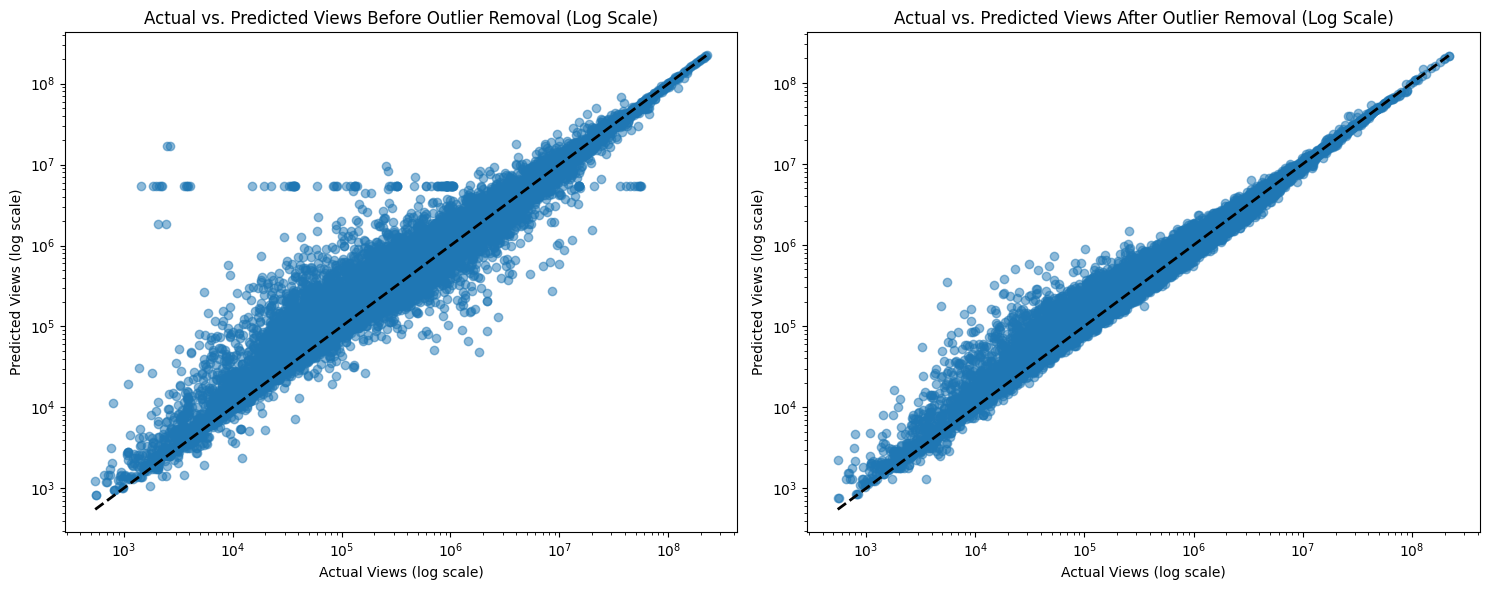

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot actual vs. predicted views before outlier removal
axes[0].scatter(y + 1, y_pred_rf_final + 1, alpha=0.5)
axes[0].plot([y.min() + 1, y.max() + 1], [y.min() + 1, y.max() + 1], 'k--', lw=2)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Actual Views (log scale)')
axes[0].set_ylabel('Predicted Views (log scale)')
axes[0].set_title('Actual vs. Predicted Views Before Outlier Removal (Log Scale)')

# Plot actual vs. predicted views after outlier removal
axes[1].scatter(cleaned_y + 1, y_pred_rf_final_cleaned + 1, alpha=0.5)
axes[1].plot([cleaned_y.min() + 1, cleaned_y.max() + 1], [cleaned_y.min() + 1, cleaned_y.max() + 1], 'k--', lw=2)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Actual Views (log scale)')
axes[1].set_ylabel('Predicted Views (log scale)')
axes[1].set_title('Actual vs. Predicted Views After Outlier Removal (Log Scale)')

plt.tight_layout()
plt.show()

In [13]:
# number of outliers removed
len(df) - len(cleaned_X)

1958

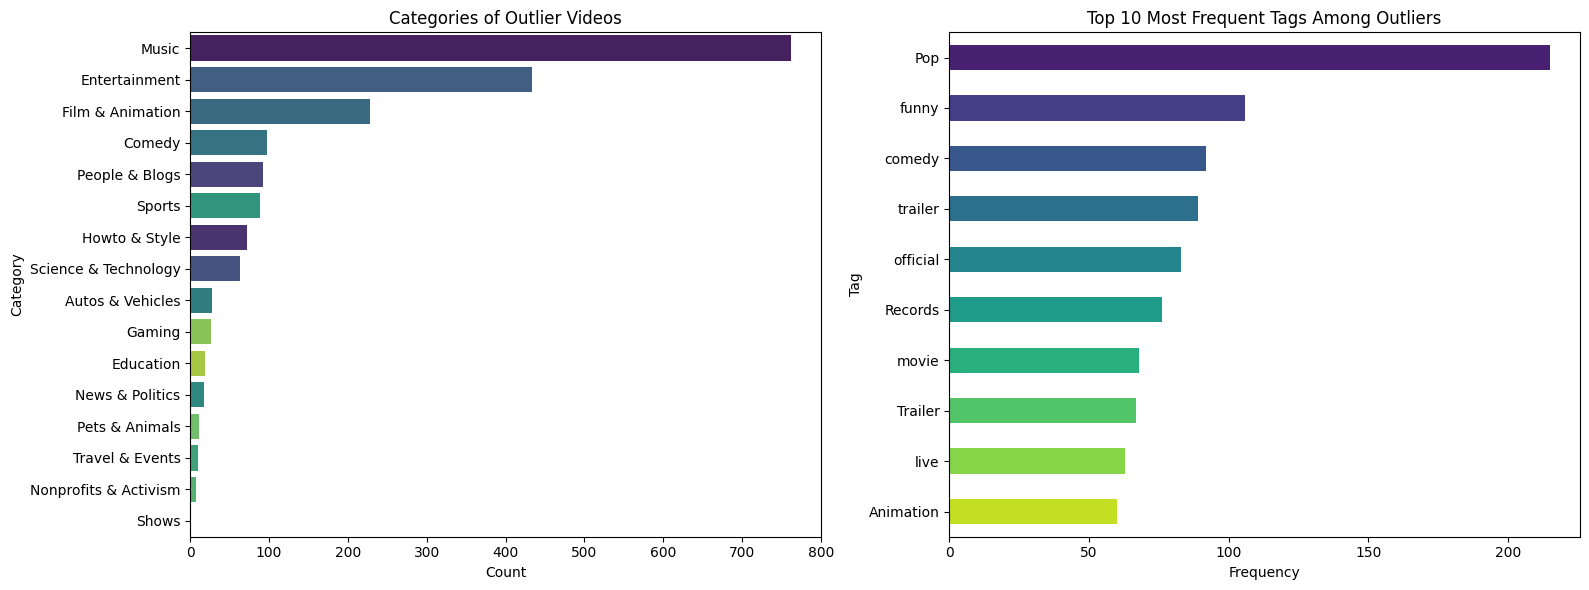

In [14]:
# Prepare data for outliers
outliers_df = df[outliers]
category_counts = outliers_df['category'].value_counts()

# Tag processing
outlier_tags = outliers_df['tags'].apply(lambda x: [item.strip('"') for item in x.split('|')])
outlier_tags_expanded = [item for sublist in outlier_tags for item in sublist]
outlier_tag_counts = pd.Series(outlier_tags_expanded).value_counts()

# Plotting
N = 10
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot 1: Outliers category count
sns.countplot(
    data=outliers_df,
    y='category',
    hue='category',
    order=category_counts.index,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Categories of Outlier Videos')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Category')

# Plot 2: Top N tags among outliers
outlier_tag_counts.nlargest(N).plot(
    kind='barh',
    color=sns.color_palette('viridis', N),
    ax=axes[1]
)
axes[1].invert_yaxis()
axes[1].set_title(f'Top {N} Most Frequent Tags Among Outliers')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Tag')

plt.tight_layout()
plt.show()